# Train Optimised Model
The optimised model from the previous workflow is trained with the features from the feature selection and the subset from the subset analysis.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble, average_linear_coeffs
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)




train_df_engineered = add_engineered_features(train_df, spo2_to_po2)
test_df_engineered = add_engineered_features(test_df, spo2_to_po2)
val_df_engineered = add_engineered_features(val_df, spo2_to_po2)

features = ['shift_raw', 'SpO2_over_PiO2',  'SpO2_squared', 'log_PiO2']


In [2]:
from sklearn.linear_model import LinearRegression

# Filter subsets where SpO₂ < 92.5%
train_sub = train_df_engineered[train_df_engineered['SpO2(%)'] < 92.5]
test_sub = test_df_engineered[test_df_engineered['SpO2(%)'] < 92.5]
val_sub = val_df_engineered[val_df_engineered['SpO2(%)'] < 92.5]

# Fit ensemble of linear regression models using 10-fold CV
cv_models = fit_cv_models(
    df=train_sub,
    features=features,
    target_col='shift',
    model_class=LinearRegression,
    k=10,
    seed=42
)

# Predict using ensemble average
test_sub = test_sub.copy()
val_sub = val_sub.copy()

test_sub['y_pred'] = predict_cv_ensemble(test_sub, features, cv_models)
val_sub['y_pred'] = predict_cv_ensemble(val_sub, features, cv_models)

# Evaluate using patient-level macro averaging
test_summary = evaluate_macro_patient_level(test_sub, y_true_col='shift', y_pred_col='y_pred')
val_summary = evaluate_macro_patient_level(val_sub, y_true_col='shift', y_pred_col='y_pred')

# Print evaluation
print("Test set evaluation:")
print_evaluation(test_summary)

print("Validation set evaluation:")
print_evaluation(val_summary)

# (Optional) Average model coefficients
coefs_avg, intercept_avg = average_linear_coeffs(cv_models)
print("Average coefficients:", coefs_avg)
print("Average intercept:", intercept_avg)


Test set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.626
MSE  = 1.354
RMSE = 0.722
Mean Bias Error = 0.141
MAPE = 5.913%
nRMSE = 4.212%
Validation set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.490
MSE  = 0.624
RMSE = 0.534
Mean Bias Error = 0.009
MAPE = 4.119%
nRMSE = 2.741%
Average coefficients: [ 6.33315383e-02  3.86336789e+00 -2.26074453e-03  3.30459340e+01]
Average intercept: -86.46825432071675


In [4]:
from sklearn.linear_model import LinearRegression

# Filter subsets where SpO2 < 92.5%
train_sub = train_df_engineered[train_df_engineered['SpO2(%)'] < 92.5]
test_sub = test_df_engineered[test_df_engineered['SpO2(%)'] < 92.5]
val_sub = val_df_engineered[val_df_engineered['SpO2(%)'] < 92.5]

X_train = train_sub[features]
y_train = train_sub['shift']

X_test = test_sub[features]
y_test = test_sub['shift']

X_val = val_sub[features]
y_val = val_sub['shift']

# Train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
test_pred = lr.predict(X_test)
val_pred = lr.predict(X_val)

test_sub['y_pred'] = test_pred
val_sub['y_pred'] = val_pred

test_summary = evaluate_macro_patient_level(test_sub, y_true_col='shift', y_pred_col='y_pred')
val_summary = evaluate_macro_patient_level(val_sub, y_true_col='shift', y_pred_col='y_pred')

# Evaluate using provided functions
print("Test set evaluation:")
print_evaluation(test_summary)

print("Validation set evaluation:")
print_evaluation(val_summary)

Test set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.626
MSE  = 1.357
RMSE = 0.722
Mean Bias Error = 0.141
MAPE = 5.916%
nRMSE = 4.214%
Validation set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.490
MSE  = 0.623
RMSE = 0.534
Mean Bias Error = 0.009
MAPE = 4.118%
nRMSE = 2.740%


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/4152743206.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sub['y_pred'] = test_pred
/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/4152743206.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_sub['y_pred'] = val_pred


## Logging

In [5]:
description = f'''
Model: Optimized Linear Regression Model
Description: This is a model that is trained on the optimal features derived from the forward stepwise selection process and on the subset of patients with SpO₂ < 92.5%.
Features: {', '.join(features)}
Target: shift
Notes: patient-level macro metrics, ODC from neonatal table
'''

# Filter only scalar (JSON-serializable) entries
json_test_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in test_summary.items()
    if not isinstance(v, pd.Series)
}
json_val_metrics = {
    k: float(v) if isinstance(v, (np.generic, np.float64, np.float32)) else v
    for k, v in val_summary.items()
    if not isinstance(v, pd.Series)
}

json_path = RESULTS_PATH / "single_point_model_metrics_log.json"

log_run_json(
    identifier="Optimized Linear Regression",
    model_type="Linear Regression",
    features=features,
    train_subset="full train set",
    test_subset="full test set",
    val_subset="full validation set",  
    description=description,
    test_metrics=json_test_metrics,
    val_metrics=json_val_metrics,

    json_path=json_path
)


⚠️  Skipped duplicate log entry.


## Bland Altman Plots

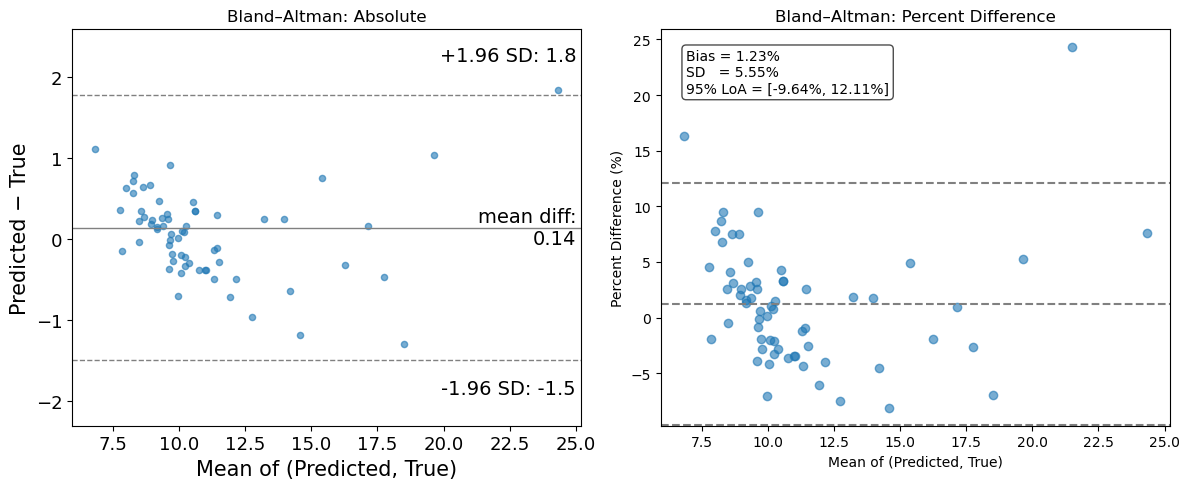

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [6]:
bland_altman_plots(test_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


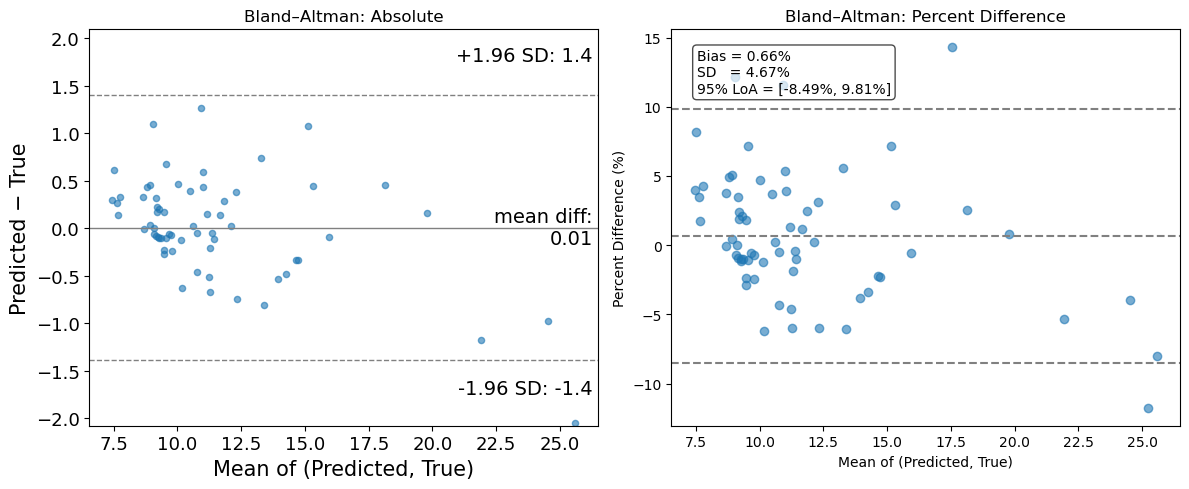

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [7]:
bland_altman_plots(val_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


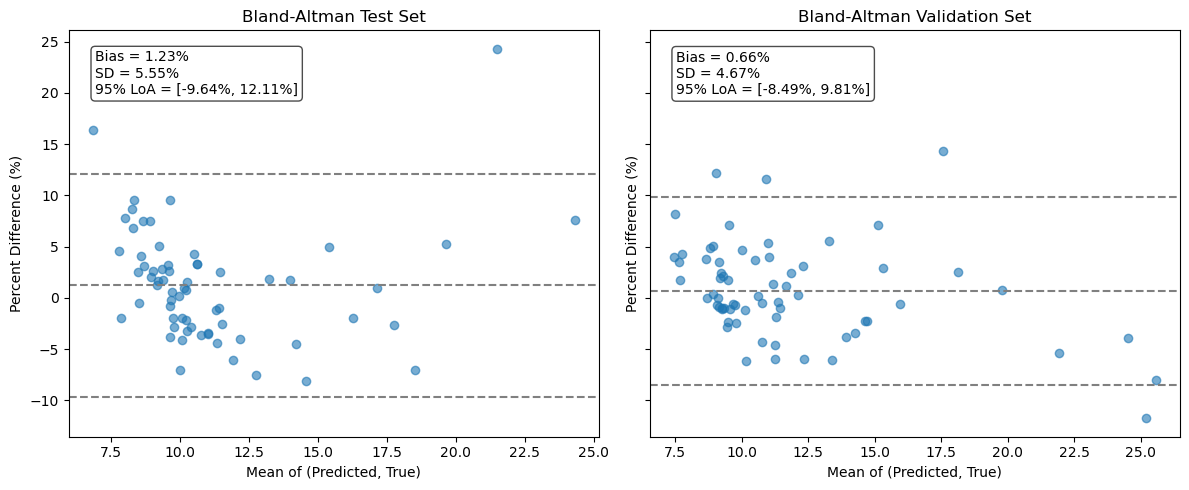

In [8]:
fig, axs = bland_altman_pct_comparison(test_sub, val_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')

## Actual vs. Predicted Plots

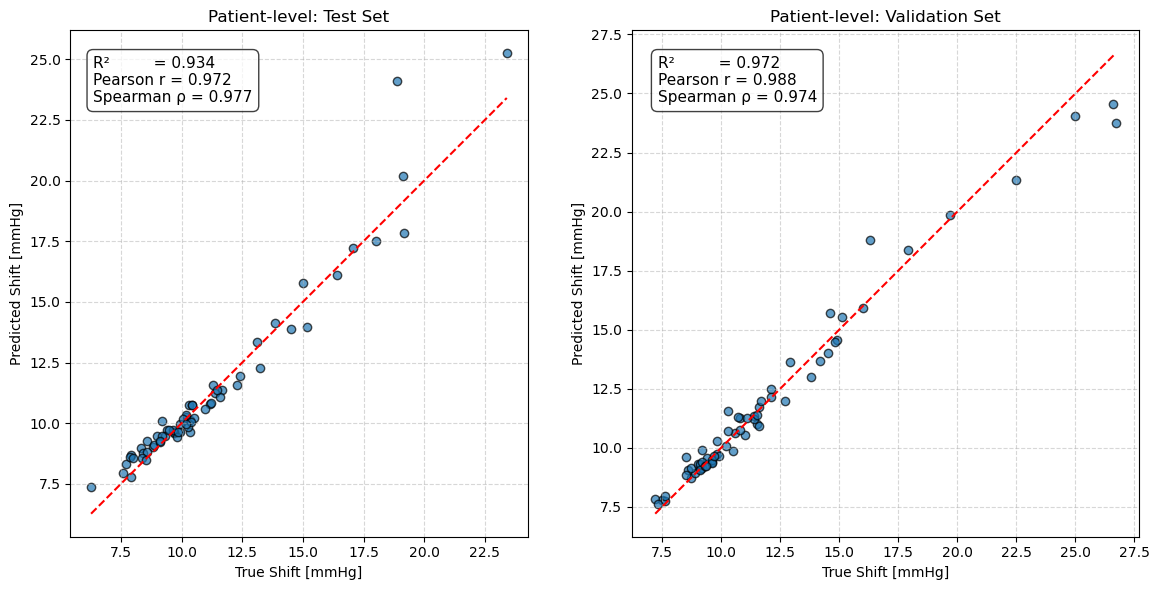

In [9]:

from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

# Group by patient and take mean shift and prediction per patient
test_avg = test_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].mean().reset_index()
val_avg = val_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].mean().reset_index()

# Compute stats
r2_test = r2_score(test_avg['shift'], test_avg['y_pred'])
pearson_test, _ = pearsonr(test_avg['shift'], test_avg['y_pred'])
spearman_test, _ = spearmanr(test_avg['shift'], test_avg['y_pred'])

r2_val = r2_score(val_avg['shift'], val_avg['y_pred'])
pearson_val, _ = pearsonr(val_avg['shift'], val_avg['y_pred'])
spearman_val, _ = spearmanr(val_avg['shift'], val_avg['y_pred'])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Test set
axs[0].scatter(test_avg['shift'], test_avg['y_pred'], alpha=0.7, edgecolors='k')
axs[0].plot([test_avg['shift'].min(), test_avg['shift'].max()],
            [test_avg['shift'].min(), test_avg['shift'].max()], 'r--', label='Identity line')
axs[0].set_title("Patient-level: Test Set")
axs[0].set_xlabel("True Shift [mmHg]")
axs[0].set_ylabel("Predicted Shift [mmHg]")
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(True, linestyle='--', alpha=0.5)
textstr_test = (
    f"R²         = {r2_test:.3f}\n"
    f"Pearson r = {pearson_test:.3f}\n"
    f"Spearman ρ = {spearman_test:.3f}"
)
axs[0].text(0.05, 0.95, textstr_test, transform=axs[0].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

# Validation set
axs[1].scatter(val_avg['shift'], val_avg['y_pred'], alpha=0.7, edgecolors='k')
axs[1].plot([val_avg['shift'].min(), val_avg['shift'].max()],
            [val_avg['shift'].min(), val_avg['shift'].max()], 'r--', label='Identity line')
axs[1].set_title("Patient-level: Validation Set")
axs[1].set_xlabel("True Shift [mmHg]")
axs[1].set_ylabel("Predicted Shift [mmHg]")
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(True, linestyle='--', alpha=0.5)
textstr_val = (
    f"R²         = {r2_val:.3f}\n"
    f"Pearson r = {pearson_val:.3f}\n"
    f"Spearman ρ = {spearman_val:.3f}"
)
axs[1].text(0.05, 0.95, textstr_val, transform=axs[1].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

plt.tight_layout()
plt.show()

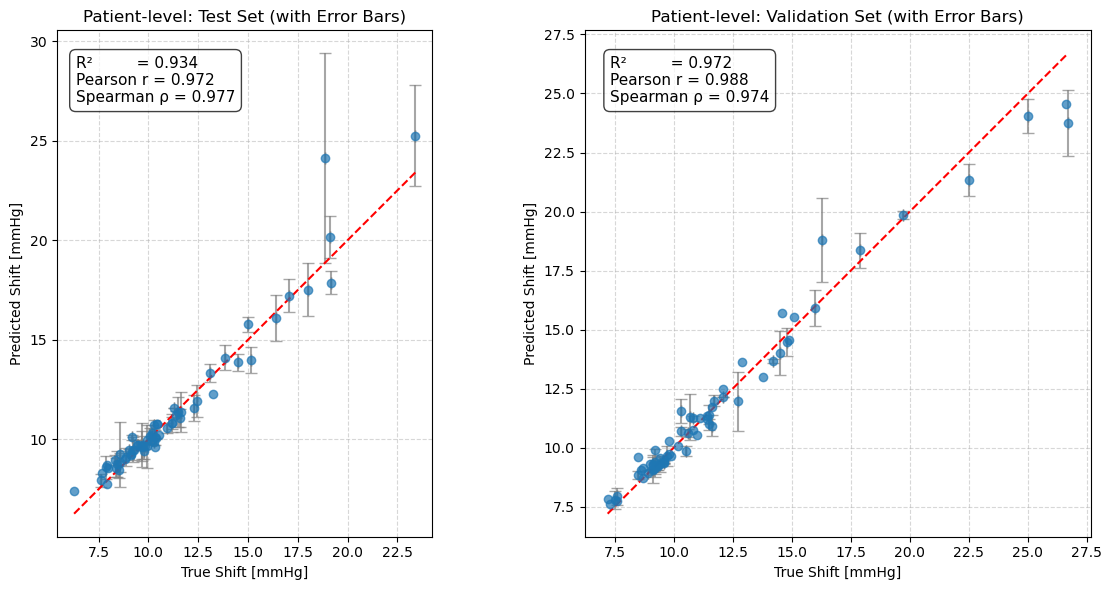

In [10]:
# Compute standard deviations for each patient
test_stats = test_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].agg(['mean', 'std']).reset_index()
val_stats = val_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].agg(['mean', 'std']).reset_index()

# Extract values for plotting
test_y_true_avg = test_stats[('shift', 'mean')]
test_y_true_std = test_stats[('shift', 'std')]
test_y_pred_avg = test_stats[('y_pred', 'mean')]
test_y_pred_std = test_stats[('y_pred', 'std')]

val_y_true_avg = val_stats[('shift', 'mean')]
val_y_true_std = val_stats[('shift', 'std')]
val_y_pred_avg = val_stats[('y_pred', 'mean')]
val_y_pred_std = val_stats[('y_pred', 'std')]

# Plot with error bars
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Test set
axs[0].errorbar(test_y_true_avg, test_y_pred_avg,
                xerr=test_y_true_std, yerr=test_y_pred_std,
                fmt='o', alpha=0.7, ecolor='gray', capsize=4)
axs[0].plot([test_y_true_avg.min(), test_y_true_avg.max()],
            [test_y_true_avg.min(), test_y_true_avg.max()], 'r--')
axs[0].set_title("Patient-level: Test Set (with Error Bars)")
axs[0].set_xlabel("True Shift [mmHg]")
axs[0].set_ylabel("Predicted Shift [mmHg]")
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].text(0.05, 0.95, textstr_test, transform=axs[0].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

# Validation set
axs[1].errorbar(val_y_true_avg, val_y_pred_avg,
                xerr=val_y_true_std, yerr=val_y_pred_std,
                fmt='o', alpha=0.7, ecolor='gray', capsize=4)
axs[1].plot([val_y_true_avg.min(), val_y_true_avg.max()],
            [val_y_true_avg.min(), val_y_true_avg.max()], 'r--')
axs[1].set_title("Patient-level: Validation Set (with Error Bars)")
axs[1].set_xlabel("True Shift [mmHg]")
axs[1].set_ylabel("Predicted Shift [mmHg]")
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].text(0.05, 0.95, textstr_val, transform=axs[1].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

plt.tight_layout()
plt.show()


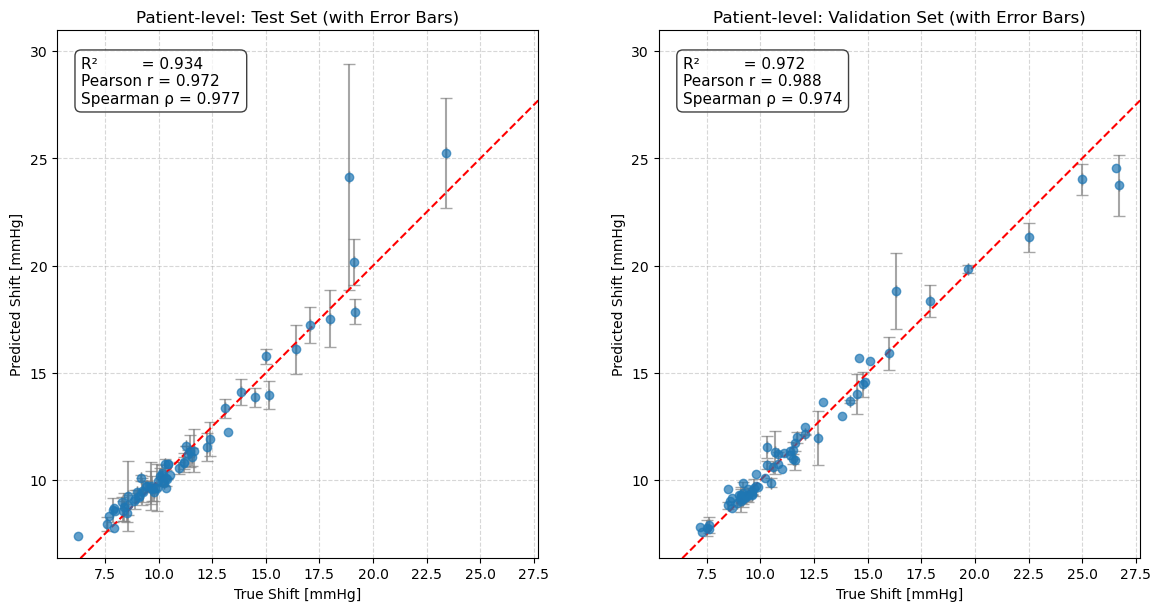

In [11]:
import matplotlib.pyplot as plt

# Compute shared axis limits
x_min = min(test_y_true_avg.min(), val_y_true_avg.min())
x_max = max(test_y_true_avg.max(), val_y_true_avg.max())
y_min = min(test_y_pred_avg.min(), val_y_pred_avg.min())
y_max = 30

# Compute limits with a bit of padding
margin = 1
xlim = (x_min - margin, x_max + margin)
ylim = (y_min - margin, y_max + margin)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Test set
axs[0].errorbar(test_y_true_avg, test_y_pred_avg,
                xerr=test_y_true_std, yerr=test_y_pred_std,
                fmt='o', alpha=0.7, ecolor='gray', capsize=4)
axs[0].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].set_title("Patient-level: Test Set (with Error Bars)")
axs[0].set_xlabel("True Shift [mmHg]")
axs[0].set_ylabel("Predicted Shift [mmHg]")
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].text(0.05, 0.95, textstr_test, transform=axs[0].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

# Validation set
axs[1].errorbar(val_y_true_avg, val_y_pred_avg,
                xerr=val_y_true_std, yerr=val_y_pred_std,
                fmt='o', alpha=0.7, ecolor='gray', capsize=4)
axs[1].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].set_title("Patient-level: Validation Set (with Error Bars)")
axs[1].set_xlabel("True Shift [mmHg]")
axs[1].set_ylabel("Predicted Shift [mmHg]")
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].text(0.05, 0.95, textstr_val, transform=axs[1].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

plt.show()


## Export Result Table

In [12]:
metrics = ['MAE', 'MSE', 'RMSE', 'Mean Bias Error', 'MAPE', 'nRMSE']
summary_df = pd.DataFrame({
    'Metric': metrics,
    'Test': [test_summary[m] for m in metrics],
    'Validation': [val_summary[m] for m in metrics]
}).round(3)

# Export to CSV
output_path = RESULTS_PATH / "linear regression" / "optimized_metrics_summary.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
summary_df.to_csv(output_path, index=False)

# Display table
summary_df

,Metric,Test,Validation
0,MAE,0.626,0.490
1,MSE,1.357,0.623
2,RMSE,0.722,0.534
3,Mean Bias Error,0.141,0.009
4,MAPE,5.916,4.118
5,nRMSE,4.214,2.740


## Inter-Patient Variability

In [13]:
# For test or val set:
df = test_sub  # or val_sub
patient_errors = df.groupby('Anon.Patient_ID').apply(
    lambda group: np.mean(np.abs(group['y_pred'] - group['shift']))
)


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/2698432768.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_errors = df.groupby('Anon.Patient_ID').apply(


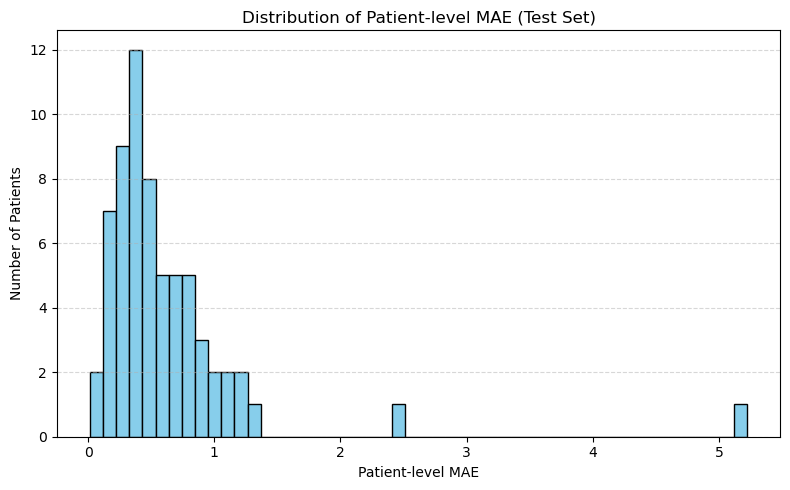

In [14]:
import matplotlib.pyplot as plt

# Plot histogram of patient_errors
plt.figure(figsize=(8, 5))
plt.hist(patient_errors, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Patient-level MAE')
plt.ylabel('Number of Patients')
plt.title('Distribution of Patient-level MAE (Test Set)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/446749871.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_errors = df.groupby("Anon.Patient_ID").apply(


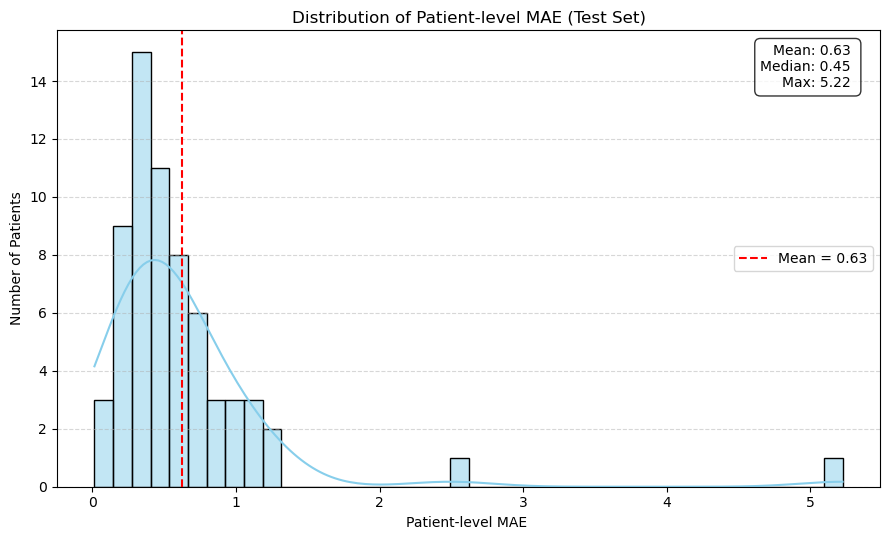

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute patient-level MAE again if needed
patient_errors = df.groupby("Anon.Patient_ID").apply(
    lambda group: np.mean(np.abs(group['y_pred'] - group['shift']))
)

# Compute stats
mean_mae = patient_errors.mean()
median_mae = patient_errors.median()
max_mae = patient_errors.max()

# Plot
plt.figure(figsize=(9, 5.5))
sns.histplot(patient_errors, bins=40, kde=True, color='skyblue', edgecolor='black')
plt.axvline(mean_mae, color='red', linestyle='--', label=f"Mean = {mean_mae:.2f}")
plt.xlabel('Patient-level MAE ')
plt.ylabel('Number of Patients')
plt.title('Distribution of Patient-level MAE (Test Set)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add annotation box
textstr = f"Mean: {mean_mae:.2f} \nMedian: {median_mae:.2f} \nMax: {max_mae:.2f} "
plt.text(0.97, 0.97, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Identify patients with highest MAE in test set
top_mae_patients = test_summary['per_patient_MAE'].sort_values(ascending=False).head(2)
print("Patients with highest MAE:")
print(top_mae_patients)

Patients with highest MAE:
Anon.Patient_ID
120    5.223488
10     2.492973
dtype: float64


In [17]:
# Add more context: mean shift, mean SpO2, std shift
patient_summary = df.groupby("Anon.Patient_ID").agg(
    mae=("shift", lambda x: np.mean(np.abs(x - df.loc[x.index, "y_pred"]))),
    count=("shift", "count"),
    mean_shift=("shift", "mean"),
    mean_spo2=("SpO2(%)", "mean"),
    std_shift=("shift", "std"),
)

Top 5 patients with highest MAE:
                      mae  count  mean_shift  mean_spo2  std_shift
Anon.Patient_ID                                                   
120              5.223488      6   18.891081  88.866667        0.0
10               2.492973      6   23.405168  89.650000        0.0
123              1.295457      5   19.154553  85.340000        0.0
68               1.230696      7   17.995566  90.385714        0.0
110              1.180593      4   15.158731  89.500000        0.0


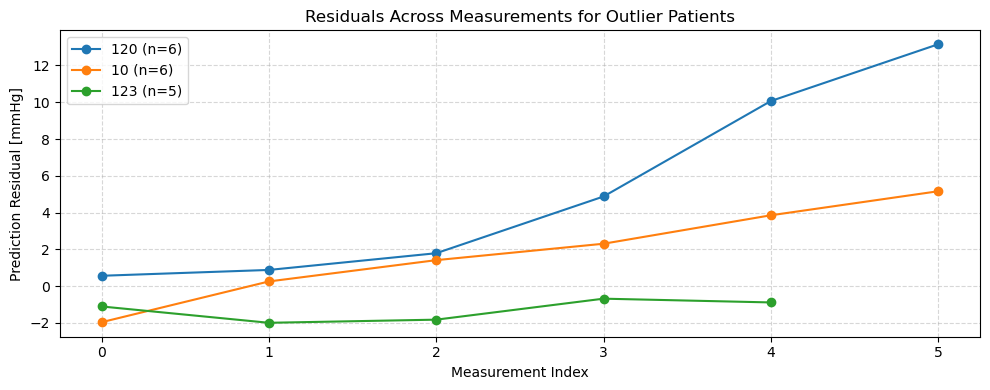

In [18]:
# Sort by MAE
top_outliers = patient_summary.sort_values(by="mae", ascending=False).head(5)

# Display
print("Top 5 patients with highest MAE:")
print(top_outliers[['mae', 'count', 'mean_shift', 'mean_spo2', 'std_shift']])

example_patients = top_outliers.index[:3]

# Plot residuals over measurement index
plt.figure(figsize=(10, 4))
for pid in example_patients:
    patient_data = df[df["Anon.Patient_ID"] == pid].copy()
    residuals = patient_data['y_pred'] - patient_data['shift']
    plt.plot(residuals.values, marker='o', label=f"{pid} (n={len(residuals)})")

plt.title("Residuals Across Measurements for Outlier Patients")
plt.xlabel("Measurement Index")
plt.ylabel("Prediction Residual [mmHg]")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [19]:
patients_of_interest = [10, 120]

for pid in patients_of_interest:
    patient_data = df[df["Anon.Patient_ID"] == pid]
    print(f"\nPatient {pid} - n = {len(patient_data)}")
    print(patient_data[["SpO2(%)", "PiO2(kPa)", "shift", "y_pred"]])



Patient 10 - n = 6
    SpO2(%)  PiO2(kPa)      shift     y_pred
9      91.5       31.5  23.405168  21.446480
10     87.1       32.7  23.405168  23.662953
11     88.0       34.6  23.405168  24.820791
12     89.8       36.6  23.405168  25.713410
13     90.6       39.2  23.405168  27.260795
14     90.9       41.3  23.405168  28.567039

Patient 120 - n = 6
     SpO2(%)  PiO2(kPa)      shift     y_pred
260     82.0       25.9  18.891081  19.456913
261     87.5       27.9  18.891081  19.774196
262     92.0       30.7  18.891081  20.683589
263     88.8       33.5  18.891081  23.768367
265     91.1       42.0  18.891081  28.958750
266     91.8       47.3  18.891081  32.045599


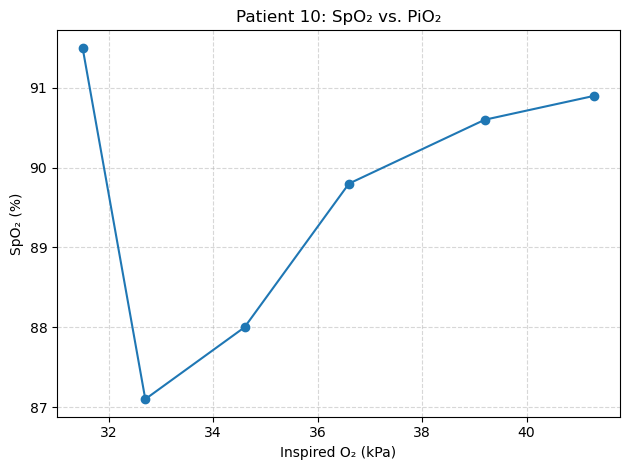

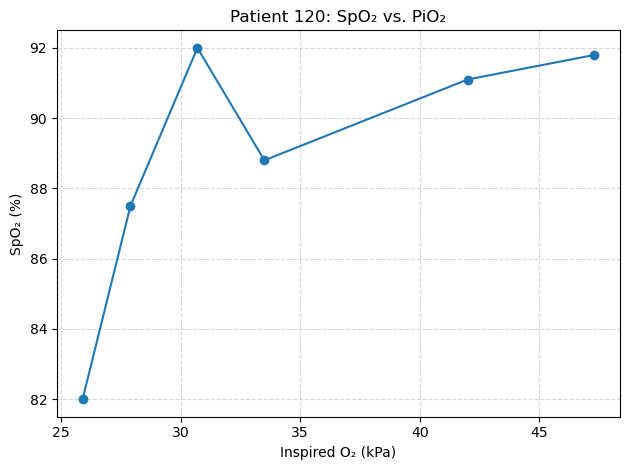

In [20]:
for pid in patients_of_interest:
    patient_data = df[df["Anon.Patient_ID"] == pid]
    plt.figure()
    plt.plot(patient_data["PiO2(kPa)"], patient_data["SpO2(%)"], 'o-')
    plt.title(f"Patient {pid}: SpO₂ vs. PiO₂")
    plt.xlabel("Inspired O₂ (kPa)")
    plt.ylabel("SpO₂ (%)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


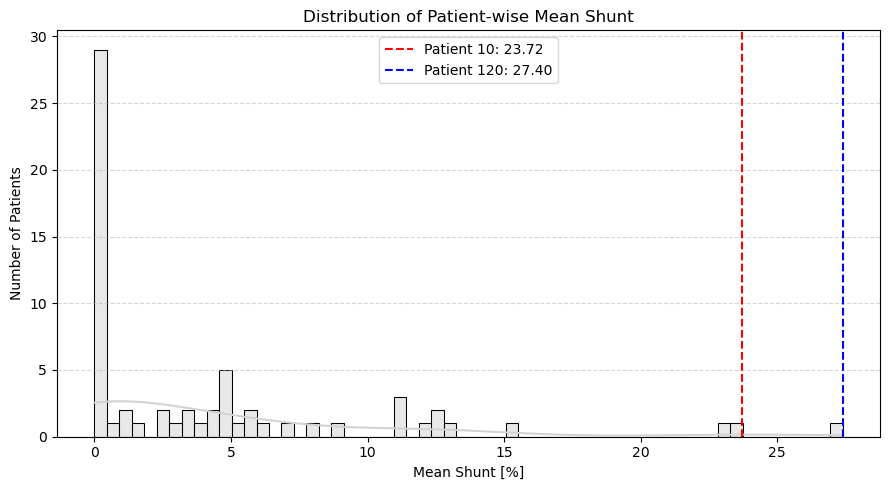

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: average shunt per patient
shunt_by_patient = df.groupby("Anon.Patient_ID")["shunt"].mean()
# Drop patient 69 from shunt_by_patient
shunt_by_patient = shunt_by_patient.drop(69)

# Step 2: extract shunt for patients 10 and 120
patients_of_interest = [10, 120]
highlighted = shunt_by_patient.loc[patients_of_interest]

# Step 3: plot full distribution with overlay
plt.figure(figsize=(9, 5))
sns.histplot(shunt_by_patient, bins=60, kde=True, color='lightgray', edgecolor='black')
plt.axvline(highlighted.iloc[0], color='red', linestyle='--', label=f'Patient 10: {highlighted.iloc[0]:.2f}')
plt.axvline(highlighted.iloc[1], color='blue', linestyle='--', label=f'Patient 120: {highlighted.iloc[1]:.2f}')
plt.xlabel("Mean Shunt [%]")
plt.ylabel("Number of Patients")
plt.title("Distribution of Patient-wise Mean Shunt")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/1390911664.py:29: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=c, edgecolor='black')


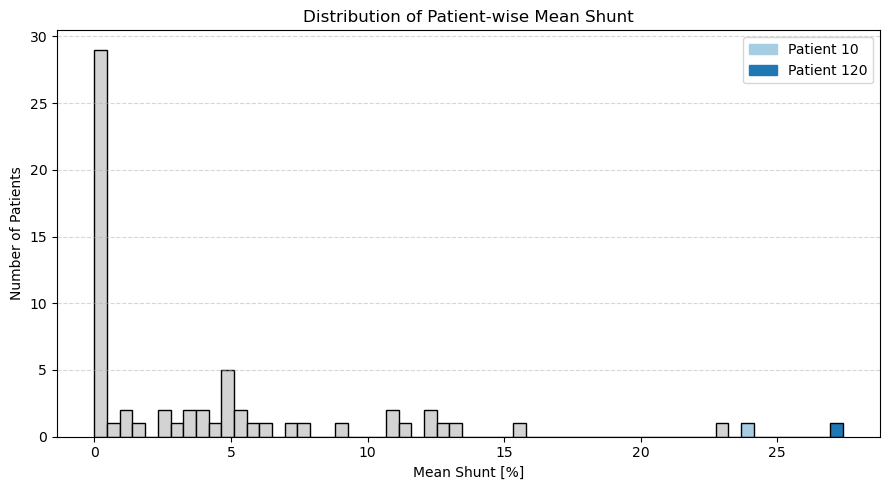

In [44]:
highlight_patients = {
    10: '#a6cee3',    # Light sky blue
    120: '#1f78b4'    # Cornflower blue
}

highlight_values = shunt_by_patient.loc[list(highlight_patients.keys())]

bins = np.linspace(shunt_by_patient.min(), shunt_by_patient.max(), 60)
counts, edges = np.histogram(shunt_by_patient, bins=bins)

# Use right=True to make sure upper-edge values fall into correct bin
bin_indices = {pid: np.digitize(val, edges, right=True) - 1 for pid, val in highlight_values.items()}

fig, ax = plt.subplots(figsize=(9, 5))

for i in range(len(counts)):
    color = 'lightgray'
    for pid, idx in bin_indices.items():
        if i == idx:
            color = highlight_patients[pid]
            break
    ax.bar(edges[i], counts[i],
           width=edges[i+1] - edges[i],
           align='edge',
           edgecolor='black',
           color=color)

custom_handles = [
    plt.Rectangle((0, 0), 1, 1, color=c, edgecolor='black') 
    for c in highlight_patients.values()
]
ax.legend(custom_handles, [f"Patient {pid}" for pid in highlight_patients.keys()])

ax.set_xlabel("Mean Shunt [%]")
ax.set_ylabel("Number of Patients")
ax.set_title("Distribution of Patient-wise Mean Shunt")
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [25]:
# Find patient with highest mean shunt in test_sub
shunt_by_patient = test_sub.groupby("Anon.Patient_ID")["shunt"].mean()
max_shunt_pid = shunt_by_patient.idxmax()
max_shunt_value = shunt_by_patient.max()

# Get MAE for this patient
mae_by_patient = test_summary['per_patient_MAE']
max_shunt_mae = mae_by_patient.loc[max_shunt_pid]

print(f"Patient with highest mean shunt: {max_shunt_pid}")
print(f"Highest mean shunt value: {max_shunt_value:.2f}")
print(f"MAE for this patient: {max_shunt_mae:.2f}")

Patient with highest mean shunt: 69
Highest mean shunt value: 52.02
MAE for this patient: 0.60


## Explore Correlations

In [22]:
from scipy.stats import pearsonr, spearmanr

# Group-level summary
patient_stats = df.groupby("Anon.Patient_ID").agg(
    mae=("shift", lambda x: np.mean(np.abs(x - df.loc[x.index, 'y_pred']))),
    mean_shunt=("shunt", "mean"),
    n_datapoints=("shift", "count")
)

# Pearson and Spearman correlation: MAE vs. shunt
pearson_shunt_r, pearson_shunt_p = pearsonr(patient_stats["mean_shunt"], patient_stats["mae"])
spearman_shunt_rho, spearman_shunt_p = spearmanr(patient_stats["mean_shunt"], patient_stats["mae"])

# Pearson and Spearman correlation: MAE vs. datapoint count
pearson_n_r, pearson_n_p = pearsonr(patient_stats["n_datapoints"], patient_stats["mae"])
spearman_n_rho, spearman_n_p = spearmanr(patient_stats["n_datapoints"], patient_stats["mae"])

# Print results
print("🔹 Correlation: MAE vs. Mean Shunt")
print(f"  Pearson r = {pearson_shunt_r:.3f} (p = {pearson_shunt_p:.3f})")
print(f"  Spearman ρ = {spearman_shunt_rho:.3f} (p = {spearman_shunt_p:.3f})")

print("\n🔹 Correlation: MAE vs. Number of Measurements")
print(f"  Pearson r = {pearson_n_r:.3f} (p = {pearson_n_p:.3f})")
print(f"  Spearman ρ = {spearman_n_rho:.3f} (p = {spearman_n_p:.3f})")


🔹 Correlation: MAE vs. Mean Shunt
  Pearson r = 0.457 (p = 0.000)
  Spearman ρ = 0.226 (p = 0.070)

🔹 Correlation: MAE vs. Number of Measurements
  Pearson r = 0.421 (p = 0.000)
  Spearman ρ = 0.384 (p = 0.002)


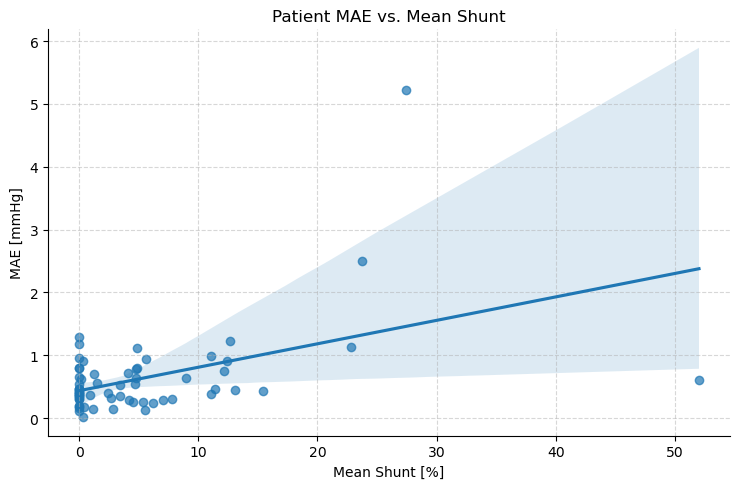

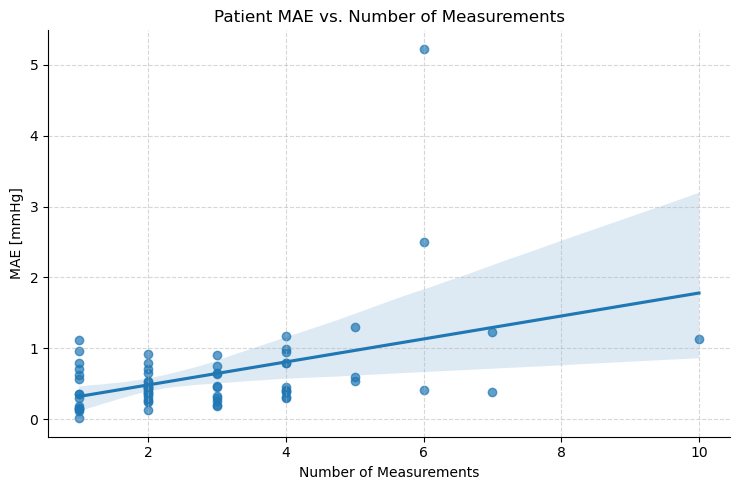

In [23]:
# MAE vs. shunt
sns.lmplot(data=patient_stats, x="mean_shunt", y="mae", aspect=1.5, scatter_kws={'alpha':0.7})
plt.title("Patient MAE vs. Mean Shunt")
plt.xlabel("Mean Shunt [%]")
plt.ylabel("MAE [mmHg]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# MAE vs. n_datapoints
sns.lmplot(data=patient_stats, x="n_datapoints", y="mae", aspect=1.5, scatter_kws={'alpha':0.7})
plt.title("Patient MAE vs. Number of Measurements")
plt.xlabel("Number of Measurements")
plt.ylabel("MAE [mmHg]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Intra-Patient Variability

In [39]:
# Compute intra-patient prediction variability
intra_variability = df.groupby("Anon.Patient_ID").agg(
    pred_std=("y_pred", "std"),
    n_datapoints=("y_pred", "count")
)

# Sort and inspect top variability cases
intra_variability_sorted = intra_variability.sort_values(by="pred_std", ascending=False)

# Top 5
print("Top 5 patients with highest prediction variability:")
print(intra_variability_sorted.head())

# Highlight specific patients
for pid in [10, 120]:
    if pid in intra_variability.index:
        print(f"\nPatient {pid}: Prediction STD = {intra_variability.loc[pid, 'pred_std']:.2f} mmHg")
    else:
        print(f"\nPatient {pid} not found.")


Top 5 patients with highest prediction variability:
                 pred_std  n_datapoints
Anon.Patient_ID                        
120              5.268613             6
10               2.546777             6
94               1.636657             4
68               1.331582             7
39               1.135916             4

Patient 10: Prediction STD = 2.55 mmHg

Patient 120: Prediction STD = 5.27 mmHg


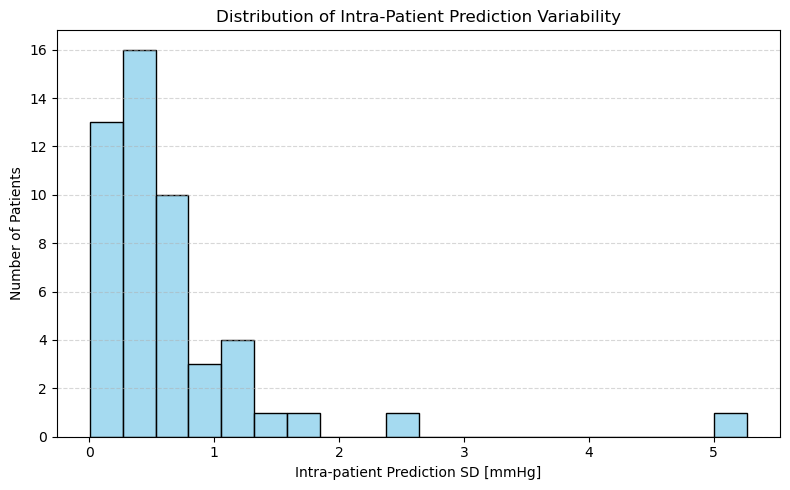

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(intra_variability["pred_std"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Intra-patient Prediction SD [mmHg]")
plt.ylabel("Number of Patients")
plt.title("Distribution of Intra-Patient Prediction Variability")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/1786223471.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_mae = df.groupby("Anon.Patient_ID").apply(


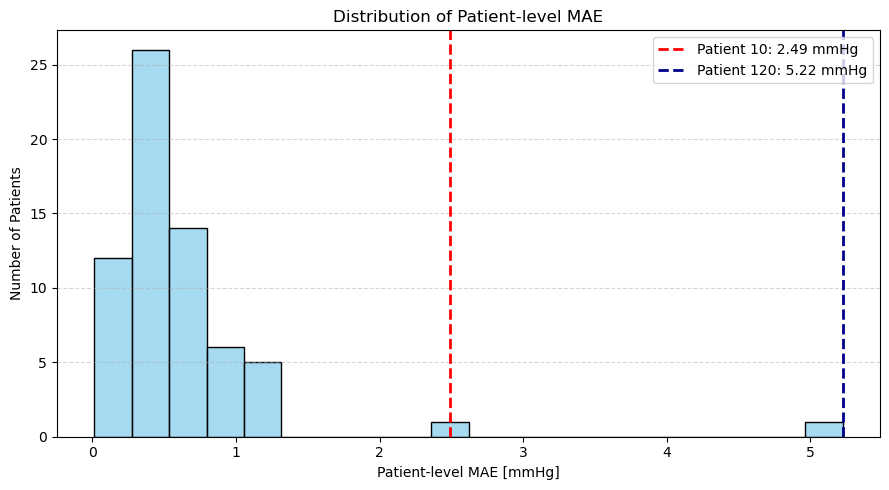

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute patient-level MAE (if not already done)
patient_mae = df.groupby("Anon.Patient_ID").apply(
    lambda g: np.mean(np.abs(g['y_pred'] - g['shift']))
)

# Get MAE values for patients 10 and 120
highlight_patients = [10, 120]
highlight_values = patient_mae.loc[highlight_patients]

# Plot histogram
plt.figure(figsize=(9, 5))
sns.histplot(patient_mae, bins=20, color='skyblue', edgecolor='black')

# Add vertical lines for highlighted patients
colors = ['red', 'darkblue']
for pid, val, color in zip(highlight_patients, highlight_values, colors):
    plt.axvline(val, color=color, linestyle='--', linewidth=2, label=f"Patient {pid}: {val:.2f} mmHg")

# Labels and style
plt.xlabel("Patient-level MAE [mmHg]")
plt.ylabel("Number of Patients")
plt.title("Distribution of Patient-level MAE")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Pearson r = 0.945, p = 0.000
Pearson r = 0.945, p = 0.000


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_17540/2393661386.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_mae = df.groupby("Anon.Patient_ID").apply(


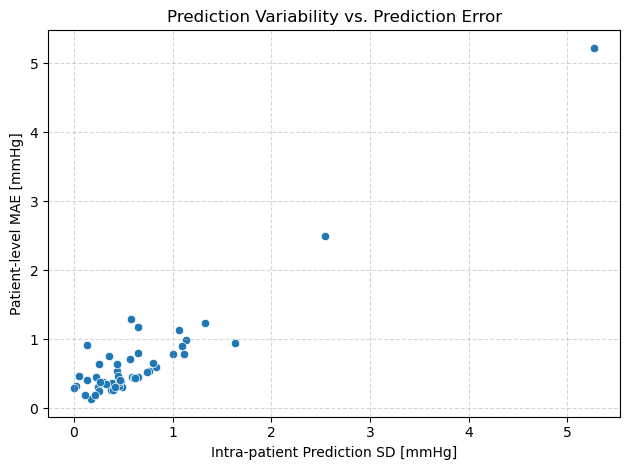

In [57]:
# Add patient MAE
patient_mae = df.groupby("Anon.Patient_ID").apply(
    lambda g: np.mean(np.abs(g['y_pred'] - g['shift']))
).rename("mae")

# Convert intra_variability to DataFrame if it's a Series
intra_variability_df = intra_variability.to_frame(name="pred_std")

# Now merge
merged = intra_variability_df.join(patient_mae)


# Drop NaNs
merged_clean = merged.dropna(subset=["pred_std", "mae"])

# Correlation
r, p = pearsonr(merged_clean["pred_std"], merged_clean["mae"])
print(f"Pearson r = {r:.3f}, p = {p:.3f}")


# Correlation
from scipy.stats import pearsonr
r, p = pearsonr(merged_clean["pred_std"], merged_clean["mae"])
print(f"Pearson r = {r:.3f}, p = {p:.3f}")

# Scatter plot
sns.scatterplot(data=merged_clean, x="pred_std", y="mae")
plt.xlabel("Intra-patient Prediction SD [mmHg]")
plt.ylabel("Patient-level MAE [mmHg]")
plt.title("Prediction Variability vs. Prediction Error")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


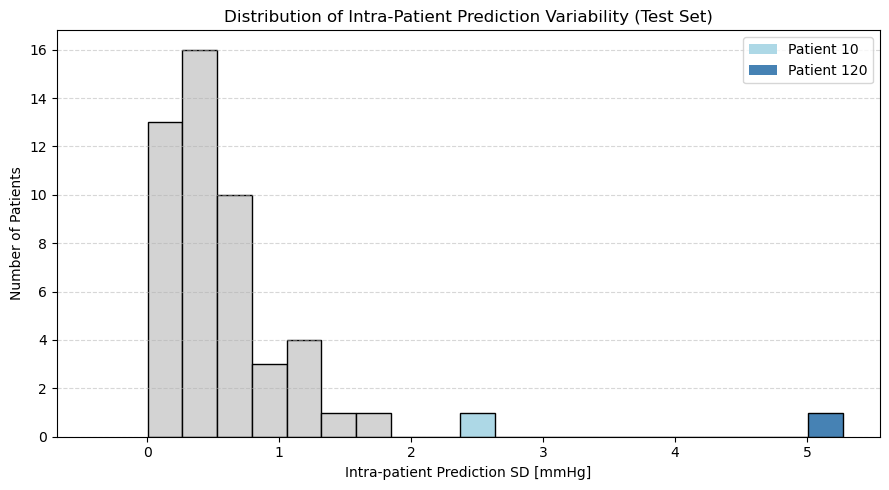

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Define patient highlights and colors
highlight_patients = [10, 120]
highlight_colors = {10: 'lightblue', 120: 'steelblue'}

# Clean data: drop NaNs
intra_variability_clean = intra_variability.dropna()

# Select only highlight patients present in the clean data
valid_highlights = [pid for pid in highlight_patients if pid in intra_variability_clean.index]
highlight_values = intra_variability_clean.loc[valid_highlights]

# Define histogram bins
bin_edges = np.histogram_bin_edges(intra_variability_clean, bins=20)
hist_vals, _ = np.histogram(intra_variability_clean, bins=bin_edges)

# Compute bin index for each highlight patient
bin_indices = {
    pid: np.digitize(val, bin_edges, right=True) - 1
    for pid, val in highlight_values.items()
}

# Plot manually, bar by bar
plt.figure(figsize=(9, 5))
for i in range(len(hist_vals)):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]
    height = hist_vals[i]
    
    # Default color
    color = 'lightgray'
    
    # Check if this bin contains any highlighted patient
    for pid, bidx in bin_indices.items():
        if i == bidx:
            color = highlight_colors[pid]
    
    plt.bar(bin_start, height, width=bin_end - bin_start, align='edge',
            edgecolor='black', color=color)

# Add legend (invisible bars for labels)
for pid in valid_highlights:
    plt.bar(0, 0, color=highlight_colors[pid], label=f'Patient {pid}')
plt.legend()

# Styling
plt.xlabel("Intra-patient Prediction SD [mmHg]")
plt.ylabel("Number of Patients")
plt.title("Distribution of Intra-Patient Prediction Variability (Test Set)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
